## Week 4: Multi-class Classification

Sign Language MNIST
* 28x28 images
* 26 letters

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import string
import csv

from tensorflow.keras import layers, losses

In [2]:
TRAINING_FILE = './data/sign_mnist_train.csv'
VALIDATION_FILE = './data/sign_mnist_test.csv'

In [3]:
def parse_data_from_input(filename):

    images = []
    labels = []

    with open(filename) as file:
        reader = csv.reader(file, delimiter=',')
        next(reader)

        for row in reader:
            images.append([int(num) for num in row[1:]])
            labels.append(int(row[0]))

        images = np.array(images, dtype=np.uint8).reshape((-1, 28, 28, 1))
        labels = np.array(labels, dtype=np.uint8)

    return images, labels 


In [4]:
x_train, y_train = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {x_train.shape} and dtype: {x_train.dtype}")
print(f"Training labels has shape: {y_train.shape} and dtype: {y_train.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")


Training images has shape: (27455, 28, 28, 1) and dtype: uint8
Training labels has shape: (27455,) and dtype: uint8
Validation images has shape: (7172, 28, 28, 1) and dtype: uint8
Validation labels has shape: (7172,) and dtype: uint8


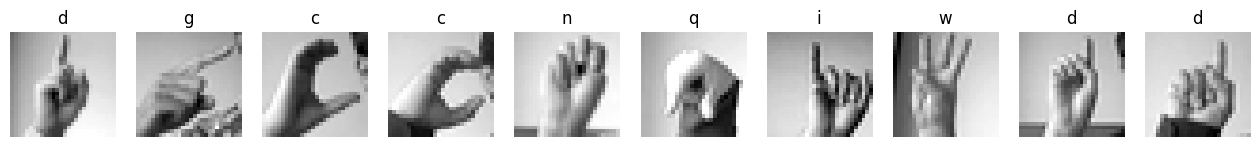

In [5]:
def plot_categories(x_train, y_train):
    letters = list(string.ascii_lowercase)

    plt.figure(figsize=(16, 15))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(x_train[i], cmap='gray')
        plt.title(letters[int(y_train[i])])
        plt.axis(False)

plot_categories(x_train, y_train)

In [6]:
def train_val_datasets(x_train, y_train, validation_images, validation_labels):

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 100

    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    validation_dataset = validation_dataset.batch(BATCH_SIZE)

    return train_dataset, validation_dataset

In [7]:
train_dataset, validation_dataset = train_val_datasets(x_train, y_train, validation_images, validation_labels)

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1, input_shape=(28, 28, 1)),
    # layers.RandomTranslation(0, 0.2),
    layers.RandomZoom(0.1)
    # layers.RandomFlip('horizontal')
])

In [9]:
def create_model():

    model = tf.keras.Sequential([
        data_augmentation,
        layers.Rescaling(1/255),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(26)
    ])

    model.compile(optimizer='rmsprop',
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

In [10]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['accuracy'] > 0.99 and logs['val_accuracy'] > 0.95:
            print('\nReached 99% and 95% validation accuracy so cancelling training!')
            self.model.stop_training = True

In [11]:
callbacks = myCallback()

model = create_model()

history = model.fit(train_dataset, epochs=15, validation_data=validation_dataset, callbacks=[callbacks])

Epoch 1/15
858/858 [==============================] - 15s 14ms/step - loss: 1.2474 - accuracy: 0.6074 - val_loss: 0.4460 - val_accuracy: 0.8341
Epoch 2/15
858/858 [==============================] - 12s 14ms/step - loss: 0.2363 - accuracy: 0.9220 - val_loss: 0.3724 - val_accuracy: 0.8946
Epoch 3/15
858/858 [==============================] - 13s 15ms/step - loss: 0.0982 - accuracy: 0.9690 - val_loss: 0.2516 - val_accuracy: 0.9310
Epoch 4/15
858/858 [==============================] - 12s 14ms/step - loss: 0.0491 - accuracy: 0.9851 - val_loss: 0.2543 - val_accuracy: 0.9453
Epoch 5/15
858/858 [==============================] - 13s 15ms/step - loss: 0.0369 - accuracy: 0.9879 - val_loss: 0.3070 - val_accuracy: 0.9335
Epoch 6/15
858/858 [==============================] - 13s 16ms/step - loss: 0.0286 - accuracy: 0.9903 - val_loss: 0.3578 - val_accuracy: 0.9363
Epoch 7/15
856/858 [============================>.] - ETA: 0s - loss: 0.0238 - accuracy: 0.9921
Reached 99% and 95% validation accuracy 

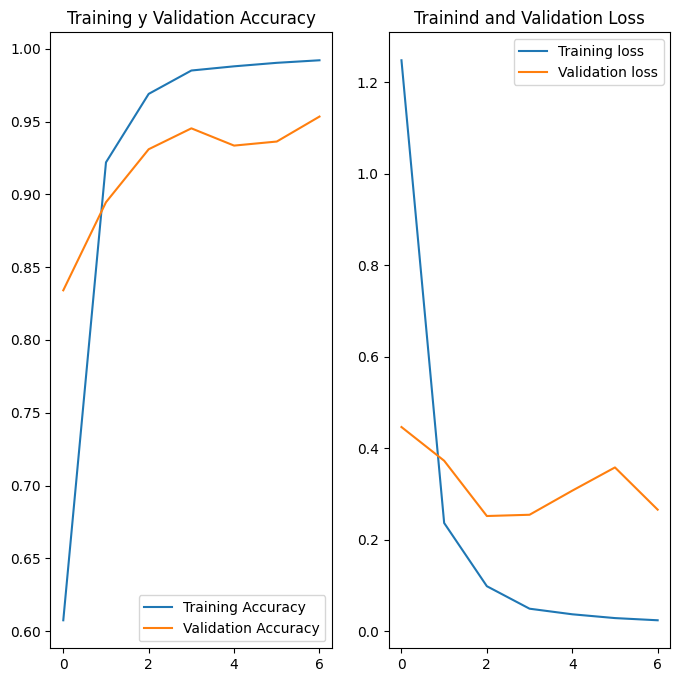

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training y Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Trainind and Validation Loss')
plt.show()